In [110]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import pylab
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

## 1. Загрузка файла

In [152]:
df_hr = pd.read_csv('HR.csv')

qual = {'satisfaction_level': df_hr.satisfaction_level, 'last_evaluation': df_hr.last_evaluation, 'number_project': df_hr.number_project, 'average_monthly_hours': df_hr.average_monthly_hours, 'time_spend_company': df_hr.time_spend_company}
quant = {'work_accident': df_hr.work_accident, 'left': df_hr.left, 'promotion_last_5years': df_hr.promotion_last_5years, 'department': df_hr.department, 'salary': df_hr.salary}

df_hr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## 2. Основные метрики

### Для количественных данных

In [153]:
df_qual = pd.DataFrame()
for key, value in qual.items():
    value = pd.to_numeric(value, errors='coerce')
    min = value.min()
    max = value.max()
    mean = round(value.mean(), 2)
    median = value.median()
    mode = value.mode()[0]
    std = round(value.std(), 2)
    row = {'series': key, 'min': min, 'max': max, 'mean': mean, 'median': median, 'mode': mode, 'std': std}
    df_qual = pd.concat([df_qual, pd.DataFrame([row])])
df_qual

,series,min,max,mean,median,mode,std
0,satisfaction_level,0.09,1.0,0.61,0.64,0.10,0.25
0,last_evaluation,0.36,1.0,0.72,0.72,0.55,0.17
0,number_project,2.00,7.0,3.80,4.00,4.00,1.23
0,average_monthly_hours,96.00,310.0,201.05,200.00,135.00,49.94
0,time_spend_company,2.00,10.0,3.50,3.00,3.00,1.46


### Для качественных данных

In [154]:
df_quant = pd.DataFrame()
for key, value in quant.items():
    mode = value.mode()[0]
    row = {'series': key, 'mode': mode}
    df_quant = pd.concat([df_quant, pd.DataFrame([row])])
df_quant

,series,mode
0,work_accident,0
0,left,0
0,promotion_last_5years,0
0,department,sales
0,salary,low


## 3. Корреляция для количественных переменных

In [155]:
corr = df_hr[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company']].corr()
corr

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786
average_monthly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000


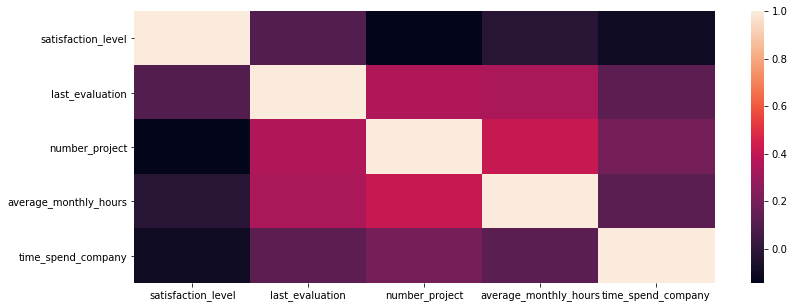

In [156]:
sns.heatmap(corr)

В основном данные между собой скоррелированы очень слабо — большинство показателей меньше 0,2 (по модулю). Слабая корреляция присутствует между **last_evaluation** и двумя переменными: **number_project (0.35)** и **average_monthly_hours (0,34)**.  Чуть более сильная положительная связь прослеживается между **average_monthly_hours** и **number_project (0,42)**: чем больше проектов, тем больше времени сотрудник проводит на работе. Наименее скоррелированные переменные — **average_monthly_hours** и **satisfaction_level (-0,02)**; едва различимая связь между ними говорит о том, что количество проведенных на работе часов практически не влияет на удовлетворенность сотрудников.


## 4. Количество сотрудников в департаментах

In [157]:
df_hr['department'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: department, dtype: int64

## 5. Распределение зарплат 

Text(0.5, 0, 'Уровень зарплаты')

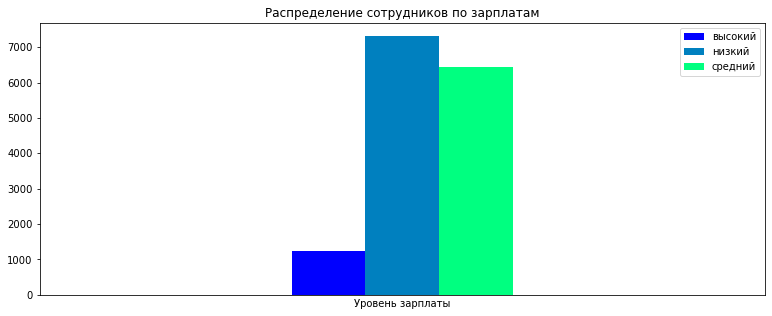

In [158]:
salary = df_hr.groupby(['salary']).agg(['count'])['left'].T
salary.plot(kind='bar', cmap='winter', width=0.22, title='Распределение сотрудников по зарплатам', rot=0)
plt.legend(labels= ['высокий', 'низкий', 'средний'])
frame = pylab.gca()
frame.axes.get_xaxis().set_ticks([])
plt.xlabel('Уровень зарплаты')

## 6. Распределение зарплат по департаментам

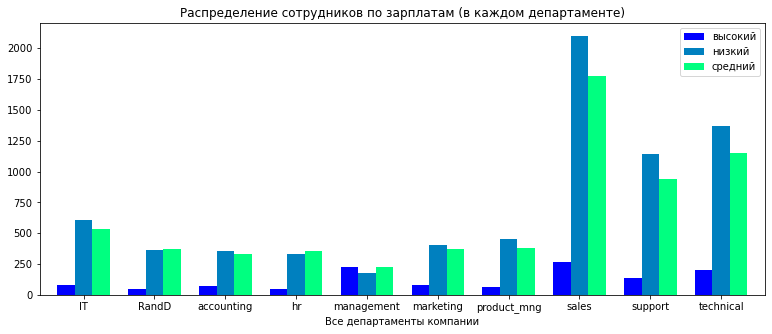

In [159]:
rcParams['figure.figsize'] = 13,5
salary_by_dept = df_hr.groupby(['department', 'salary']).agg(['count'])['left'].unstack()
salary_by_dept.plot(kind='bar', cmap='winter', width=0.74, title='Распределение сотрудников по зарплатам (в каждом департаменте)', rot=0)
plt.legend(labels= ['высокий', 'низкий', 'средний'])
plt.xlabel('Все департаменты компании');

## 7. Проверка гипотезы: чем выше зарплата, тем больше работают

In [160]:
high_sal = df_hr.loc[df_hr.salary == 'high']['average_monthly_hours']
low_sal = df_hr.loc[df_hr.salary == 'low']['average_monthly_hours']

# Выведем основные показатели двух выборок:
high_sal.describe(), low_sal.describe()

(count    1237.000000
 mean      199.867421
 std        47.710446
 min        96.000000
 25%       161.000000
 50%       199.000000
 75%       241.000000
 max       307.000000
 Name: average_monthly_hours, dtype: float64,
 count    7316.000000
 mean      200.996583
 std        50.832214
 min        96.000000
 25%       155.000000
 50%       199.000000
 75%       246.000000
 max       310.000000
 Name: average_monthly_hours, dtype: float64)

In [204]:
# Оценим различие между выборками, используя t-критерий для независимых выборок
# Нулевая гипотеза: различия между сотрудниками с высокой и низкой зарплатой статистически незначимы (выборки близки)
# Альтернативная гипотеза: высокооплачиваемые и низкооплачиваемые сотрудники работают разное количество часов
high  = stats.norm.rvs(high_sal)  
low = stats.norm.rvs(low_sal)

t,p  = stats.ttest_ind(high, low, equal_var=False)
print("t = " + str(t))
print("p = " + str(p))

t = -0.7997976486977566
p = 0.423936891784074


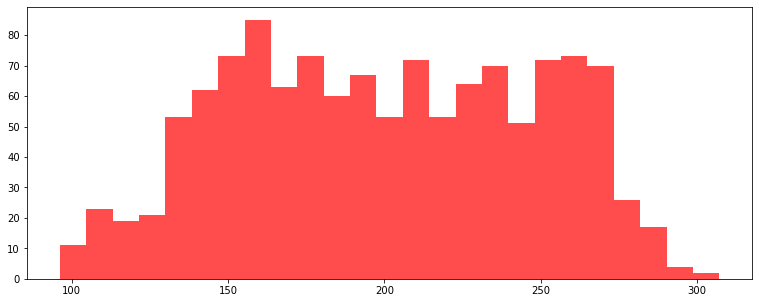

In [162]:
# Посмотрим на визуальное распределение:
plt.hist(high, bins=25, color='red', alpha=0.7);

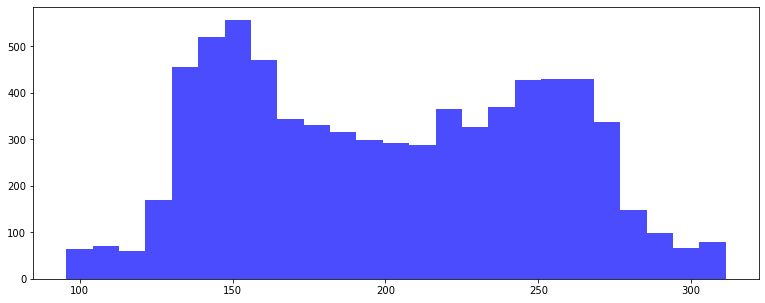

In [163]:
plt.hist(low, bins=25, color='blue', alpha=0.7);

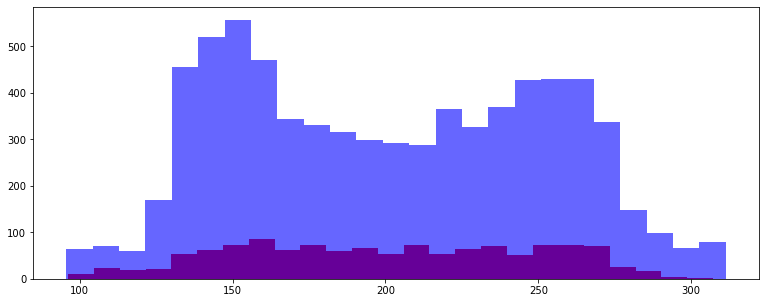

In [164]:
plt.hist(high, bins=25, color='red'); plt.hist(low, bins=25, color='blue', alpha=0.6);

Основные метрики, тест Стьюдента и гистограммы указывают на то, что выборки близки друг к другу. 

Среднее количество часов, проведенных на рабочем месте за месяц, для обеих групп практически одинаковое: 199,86 — для сотрудников с высоким окладом и 200,99 — с низким. Сотрудники и с высокой, и с низкой зарплатой провели на работе не меньше 96 часов. При этом больше двух десятков сотрудников с низкой зарплатой (26 человек) работали рекордное количество часов (больше 307), что превышает время, которое провели на работе самые трудолюбивые высокооплачиваемые специалисты.

Тест Стьюдента явно свидетельствует о близости двух выборок. Высокий p-value (0,47) означает, что нулевая гипотеза (выборки близки) имеет большую силу: если мы ее отвергнем, то вероятность ошибиться составит 47 %. Отрицательное t-значение показывает, что в среднем первая группа (высокооплачиваемые специалисты) проводила на работе немного меньше времени, но это различие не является статистически важным.  

Визуальное сравнение выборок подтверждает предыдущие вычисления: на гистограммах они имеют схожее распределение.

Таким образом, **гипотеза о том, что сотрудники с высоким окладом проводят на работе больше времени, чем сотрудники с низким окладом, не подтвердилась**. Более того, выяснилось, что некоторые низкооплачиваемые сотрудники работают на несколько часов больше (максимально на 3 часа больше), чем рекордсмены из числа высокооплачиваемых.  

## 8. Уволившиеся и неуволившиеся

In [205]:
not_left = df_hr.loc[df_hr.left == 0]
left = df_hr.loc[df_hr.left == 1]

def left_not_left(employees, i):
    df_employees = pd.DataFrame()
    promoted = employees.loc[employees.promotion_last_5years == 1].count()[0]/employees.count()[0]*100
    satisfied = employees.satisfaction_level.mean()
    projectN = employees.number_project.mean()
    row = {'category': i, 'promoted_5y_%': round(promoted, 2), 'satisfaction_level_mean': round(satisfied, 2), 'project_num_mean': round(projectN, 2)}                                                                                                             
    df_employees = pd.concat([df_employees, pd.DataFrame([row])])
    return df_employees

df_not_left = left_not_left(not_left, i=0)
df_left = left_not_left(left, i=1)
df_left_not_left = pd.concat([df_not_left, df_left])
df_left_not_left

,category,promoted_5y_%,satisfaction_level_mean,project_num_mean
0,0,2.63,0.67,3.79
0,1,0.53,0.44,3.86


Из сравнительной таблицы уволившихся (1) и неуволившихся (0) следует, что уволившиеся сотрудники в среднем были меньше удовлетворены работой (0,44 против 0,67). Среди них также меньше доля тех, кто повысился в должности за последние 5 лет (0,53 % против 2,63 %). Однако по среднему количеству проектов обе группы показывают схожий результат, близкий к четырем (3,86 и 3,79). Из этого можно сделать вывод, что увольнение, скорее всего, не было связано с большой проектной нагрузкой (согласно расчетам выше, 4 — медианное количество проектов в компании). О качественной нагрузке проектов судить невозможно.

## 9. Модель LDA

In [187]:
df = df_hr[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company']]
left_company = df_hr['left']

In [188]:
X_train, X_test, y_train, y_test = train_test_split(df, left_company, test_size=0.25)

In [189]:
lda = LinearDiscriminantAnalysis()

In [190]:
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [191]:
lda.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [192]:
accuracy_score(y_test, lda.predict(X_test))

0.7541333333333333

In [193]:
result = pd.DataFrame([y_test, lda.predict(X_test)]).T
result

,left,Unnamed 0
2258,0.0,0.0
7117,0.0,NaN
11253,0.0,NaN
1624,1.0,0.0
5693,0.0,NaN
...,...,...
10756,0.0,NaN
2496,0.0,0.0
12279,1.0,NaN
4936,0.0,NaN


In [194]:
lda.coef_

array([[-4.55568997e+00,  7.92833305e-01, -2.31529117e-01,
         3.95233284e-03,  2.03704286e-01]])

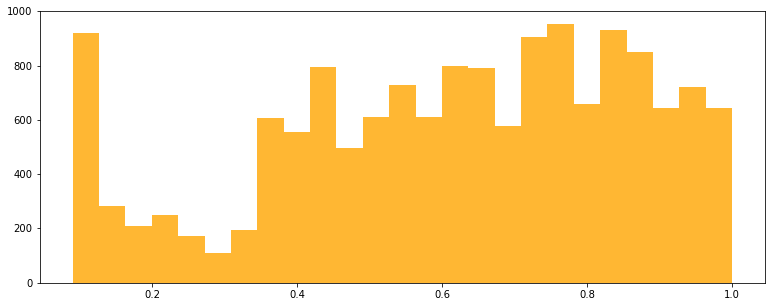

In [195]:
plt.hist(df_hr['satisfaction_level'], bins=25, color='orange', alpha=0.8);

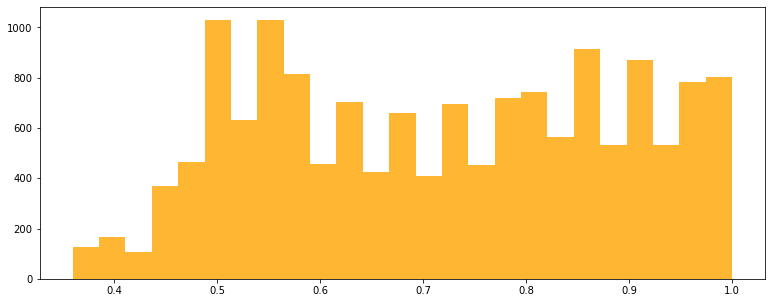

In [196]:
plt.hist(df_hr['last_evaluation'], bins=25, color='orange', alpha=0.8);

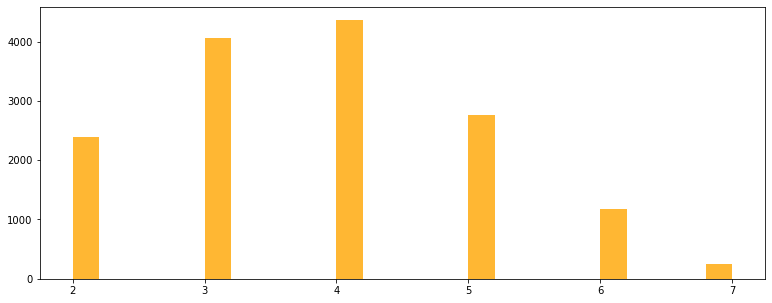

In [197]:
plt.hist(df_hr['number_project'], bins=25, color='orange', alpha=0.8);

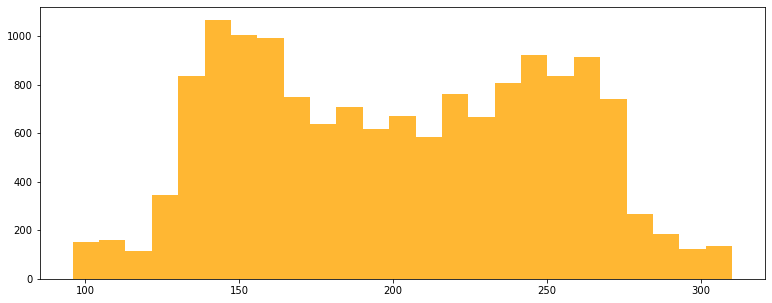

In [198]:
plt.hist(df_hr['average_monthly_hours'], bins=25, color='orange', alpha=0.8);

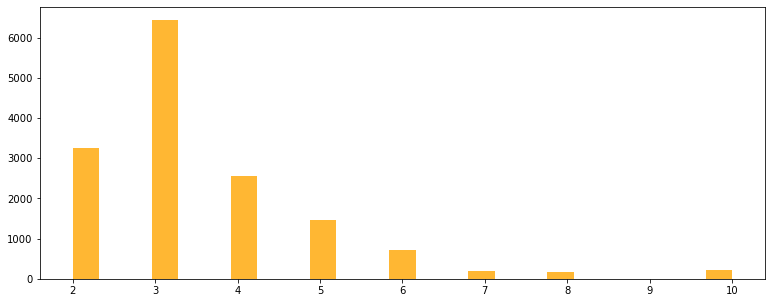

In [199]:
plt.hist(df_hr['time_spend_company'], bins=25, color='orange', alpha=0.8);

Для построения модели LDA были использованы пять факторов (пять непрерывных переменных). Уровень точности — выше среднего (75 %). Однако прогноз был выполнен программой лишь примерно для четверти тестовых данных. Остальные — не определены (NaN). Вероятно, такой результат связан с тем, что не все факторы имеют нормальное распределение (см. гистограммы). Ближе всего к нормальности — параметр количества проектов (number_project). Кроме того, судя по LDA-коэффициентам, из пяти исследуемых факторов самый заметный вклад в различение групп уволившихся и неуволившихся вносит первый параметр — уровень удовлетворенности (satisfaction_level). В группе уволившихся он падает более, чем на 4 единицы из 100. Однако он не может быть диагностическим. Так, например, среди уволившихся было немало сотрудников (22,6 %) с высоким уровнем удовлетворенности (больше 75 ед.).